In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터 로드
df_origin = pd.read_csv('2019-Oct.csv')

df = df_origin.query("brand == 'samsung' & category_code == 'electronics.smartphone'")[['event_time','event_type', 'product_id', 'price']]

# 1. 문제 탐색
## 1.1 요약 분석

In [3]:
# 원본 데이터 프레임을 복사하여 새로운 데이터 프레임 생성
dataset = df_origin.copy().query("brand == 'samsung' & category_code == 'electronics.smartphone'")

# 'category_id' 열을 제거
dataset.drop(columns=['category_id'], inplace=True)

# 'event_time' 열의 데이터 타입을 datetime으로 변환하고 시간대를 제거
dataset['event_time'] = pd.to_datetime(dataset['event_time']).dt.tz_convert(None)

# 'event_type' 열의 데이터 타입을 category로 변환
dataset['event_type'] = dataset['event_type'].astype('category')

# 'category_code' 열의 데이터 타입을 category로 변환
dataset['category_code'] = dataset['category_code'].astype('category')

In [4]:
# 일별 요약 테이블 생성을 위한 데이터 그룹화
daily_summary_table = dataset.groupby(by=[dataset['event_time'].dt.normalize()]).agg(
    number_of_daily_visits=('user_session', lambda x: x.nunique()),  # 일별 방문 횟수 계산
    number_of_daily_visitors=('user_id', lambda x: x.nunique())  # 일별 방문자 수 계산
)

# 매출 필터 설정: 이벤트 유형이 'purchase'인 경우
sales_filter = dataset['event_type'] == 'purchase'

# 매출 필터를 적용하고 일별 매출 통계를 그룹화
sales = dataset.loc[sales_filter].groupby(by=[dataset['event_time'].dt.normalize()]).agg(
    number_of_daily_sales=('event_type', 'count'),  # 일별 판매 건수 계산
    Total_daily_sales=('price', 'sum')  # 일별 매출 합계 계산
).reset_index()

# 일별 요약 테이블에 일별 매출 통계를 병합
daily_summary_table = pd.merge(
    left=daily_summary_table,
    right=sales,
    left_on=['event_time'],
    right_on=['event_time'],
    how='left'
)

# 일별 구매자 수 계산
daily_buyers = dataset[sales_filter].groupby(dataset['event_time'].dt.normalize())['user_id'].nunique().reset_index(name='number_of_daily_buyers')
daily_summary_table = daily_summary_table.merge(daily_buyers, on='event_time', how='left')

# 변환율(Conversion Rate) 계산: 일별 판매 건수 / 일별 방문 횟수
daily_summary_table['conversion_rate'] = daily_summary_table['number_of_daily_sales'] / daily_summary_table['number_of_daily_visits']

In [5]:
def daily_statistics_plot(summary_table, column_name):
    # 일별 데이터 통계 출력
    print(f'{column_name} Statistics')
    print('-' * 50)
    print(summary_table[column_name].describe())
    print('-' * 50)
    print(f'{column_name}')
    print('-' * 50)
    print(summary_table.groupby(by=summary_table['event_time'].dt.day_name())[column_name].describe())

    # 일별 데이터를 선 그래프로 표시
    fig = plt.figure(figsize=(18, 9))
    ax1 = fig.add_subplot(2, 1, 1)
    sns.lineplot(x='event_time',
                 y=column_name,
                 data=summary_table,
                 ax=ax1)
    plt.title(f'{column_name}')
    plt.ylabel(f'{column_name}')
    plt.xlabel('Dates')

    # 요일별 데이터를 박스 플롯으로 표시
    ax2 = fig.add_subplot(2, 1, 2)
    sns.boxplot(x=summary_table['event_time'].dt.dayofweek,
                y=column_name,
                data=summary_table,
                ax=ax2)
    plt.title(f'{column_name} by days')
    plt.ylabel(f'{column_name}')
    plt.xlabel('Days')
    plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    fig.tight_layout(pad=3.0)
    plt.show()

In [6]:
daily_summary_table.columns

Index(['event_time', 'number_of_daily_visits', 'number_of_daily_visitors',
       'number_of_daily_sales', 'Total_daily_sales', 'number_of_daily_buyers',
       'conversion_rate'],
      dtype='object')

number_of_daily_visits Statistics
--------------------------------------------------
count       31.000000
mean     40848.870968
std       4210.040014
min      35526.000000
25%      36817.500000
50%      41338.000000
75%      43553.500000
max      50001.000000
Name: number_of_daily_visits, dtype: float64
--------------------------------------------------
number_of_daily_visits
--------------------------------------------------
            count      mean          std      min       25%      50%  \
event_time                                                             
Friday        4.0  44861.00  2622.798887  42760.0  43509.25  43999.5   
Monday        4.0  39876.25  4284.296626  35526.0  36535.50  40118.5   
Saturday      4.0  41194.75  4653.122276  37703.0  37803.50  39727.0   
Sunday        4.0  42459.25  5407.122918  37176.0  39969.00  41330.0   
Thursday      5.0  39516.40  3009.953538  36106.0  36448.00  40781.0   
Tuesday       5.0  39398.60  4585.703850  36033.0  36452.00  3654

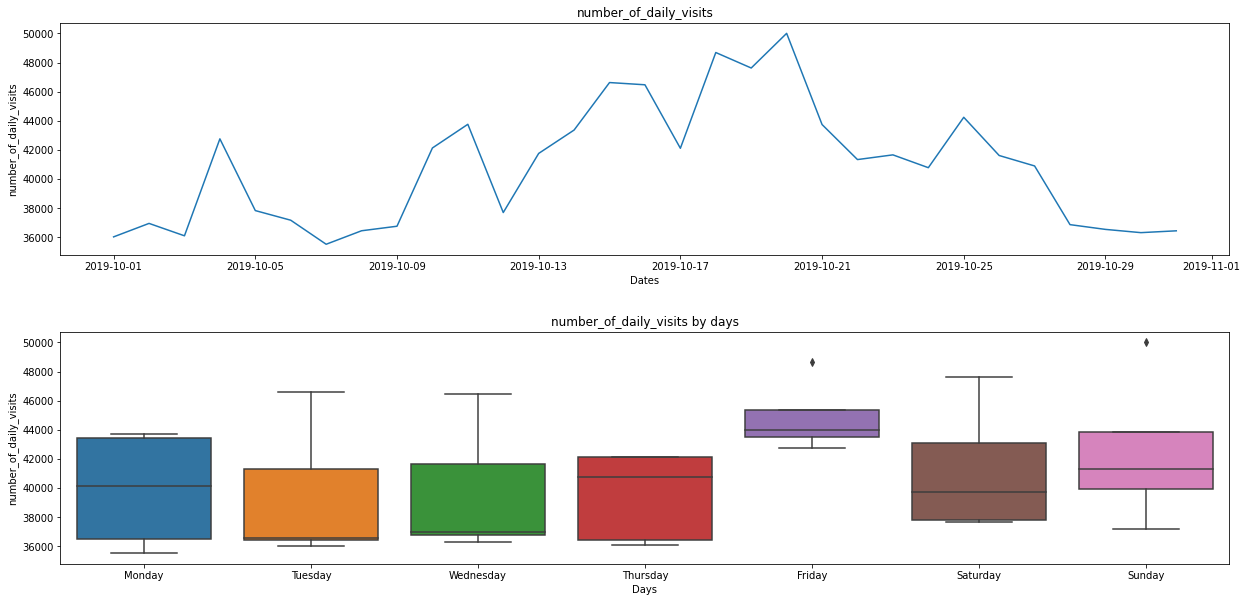

In [7]:
# 일별 방문 통계 출력
daily_statistics_plot(daily_summary_table, 'number_of_daily_visits')

number_of_daily_visitors Statistics
--------------------------------------------------
count       31.000000
mean     32721.677419
std       3306.440678
min      28563.000000
25%      29646.000000
50%      33272.000000
75%      34567.500000
max      39792.000000
Name: number_of_daily_visitors, dtype: float64
--------------------------------------------------
number_of_daily_visitors
--------------------------------------------------
            count      mean          std      min       25%      50%  \
event_time                                                             
Friday        4.0  35894.75  2048.485681  34366.0  34657.75  35171.0   
Monday        4.0  31848.00  3448.878948  28563.0  29046.75  31794.0   
Saturday      4.0  32932.00  3471.837650  30240.0  30398.25  31902.0   
Sunday        4.0  33862.25  4194.399947  29965.0  31806.25  32846.0   
Thursday      5.0  31651.00  2383.651086  29035.0  29147.00  32619.0   
Tuesday       5.0  31699.20  3606.798470  29033.0  29158.00

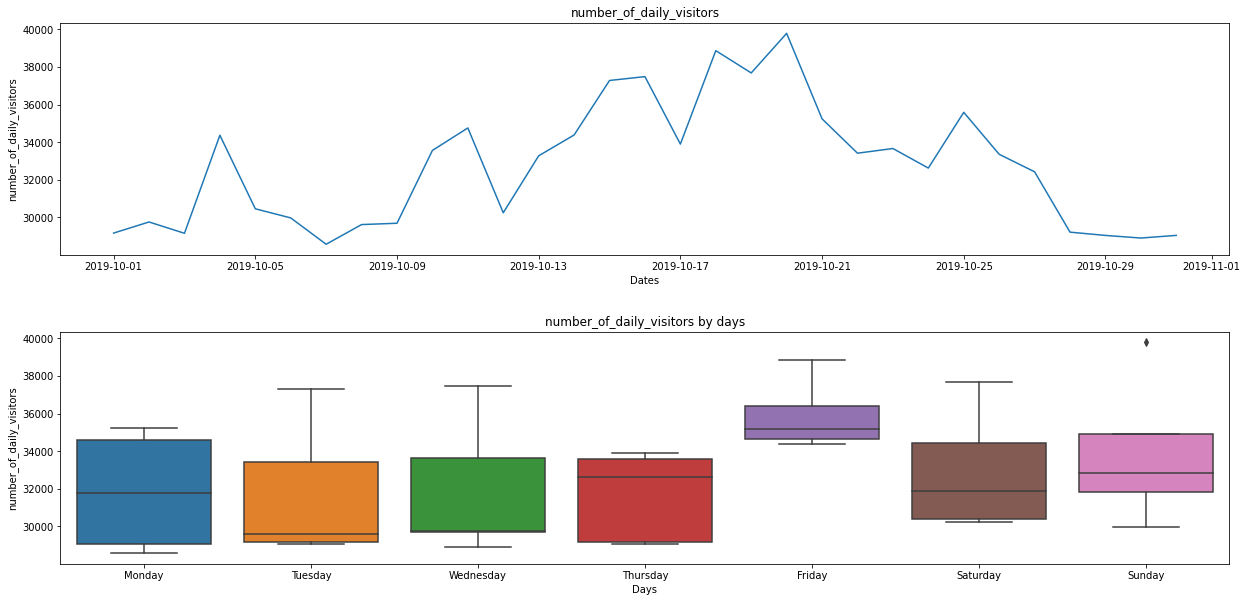

In [8]:
# 일별 방문자 통계 출력
daily_statistics_plot(daily_summary_table, 'number_of_daily_visitors')

number_of_daily_sales Statistics
--------------------------------------------------
count      31.000000
mean     4616.870968
std       665.073667
min      3742.000000
25%      4136.500000
50%      4548.000000
75%      4873.500000
max      6708.000000
Name: number_of_daily_sales, dtype: float64
--------------------------------------------------
number_of_daily_sales
--------------------------------------------------
            count     mean          std     min      25%     50%      75%  \
event_time                                                                  
Friday        4.0  4894.50   382.365009  4448.0  4646.75  4927.0  5174.75   
Monday        4.0  4739.75   778.646422  4131.0  4158.00  4519.0  5100.75   
Saturday      4.0  4502.50   278.233116  4255.0  4312.00  4439.5  4630.00   
Sunday        4.0  4586.25   307.751388  4142.0  4498.25  4698.5  4786.50   
Thursday      5.0  4469.40   769.244629  3837.0  3912.00  4131.0  4801.00   
Tuesday       5.0  4457.80   682.111208  

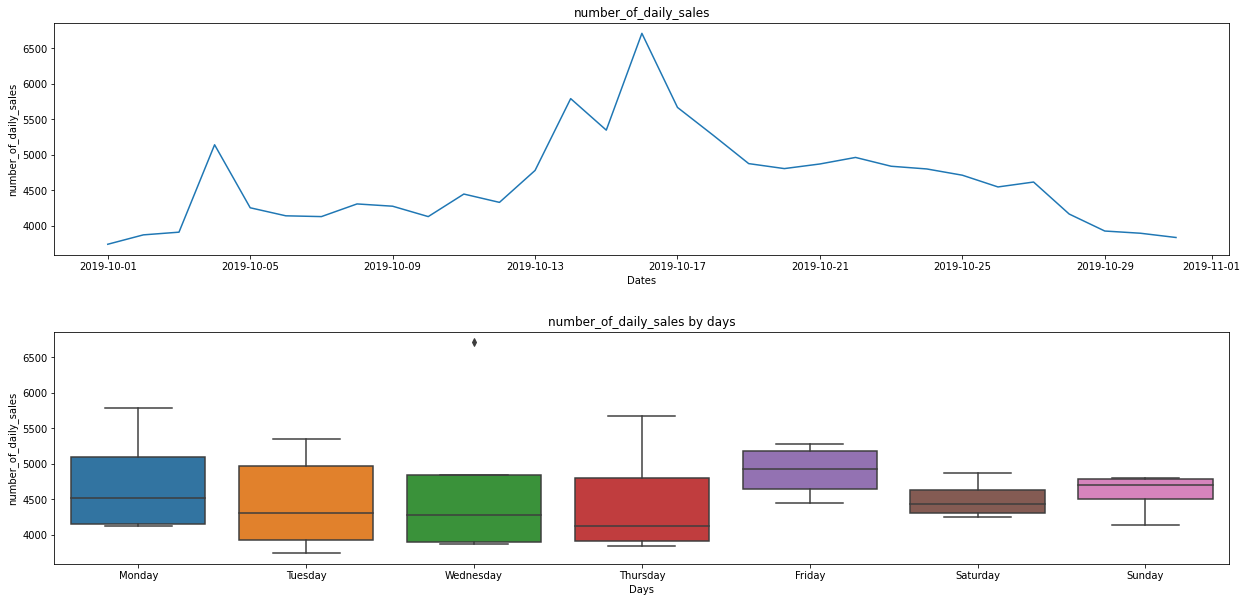

In [9]:
# 일별 구매 통계 출력
daily_statistics_plot(daily_summary_table, 'number_of_daily_sales')

Total_daily_sales Statistics
--------------------------------------------------
count    3.100000e+01
mean     1.205602e+06
std      1.624253e+05
min      1.022791e+06
25%      1.083198e+06
50%      1.174312e+06
75%      1.268494e+06
max      1.684203e+06
Name: Total_daily_sales, dtype: float64
--------------------------------------------------
Total_daily_sales
--------------------------------------------------
            count         mean            std         min           25%  \
event_time                                                                
Friday        4.0  1276112.375  104707.834745  1163921.55  1.203230e+06   
Monday        4.0  1231991.130  193812.603121  1083024.25  1.094621e+06   
Saturday      4.0  1160947.155   53076.916599  1096939.40  1.135409e+06   
Sunday        4.0  1203927.510   96667.855790  1083372.61  1.165318e+06   
Thursday      5.0  1159166.904  191946.049520  1022790.63  1.028166e+06   
Tuesday       5.0  1187127.082  179323.554338  1031281.30  

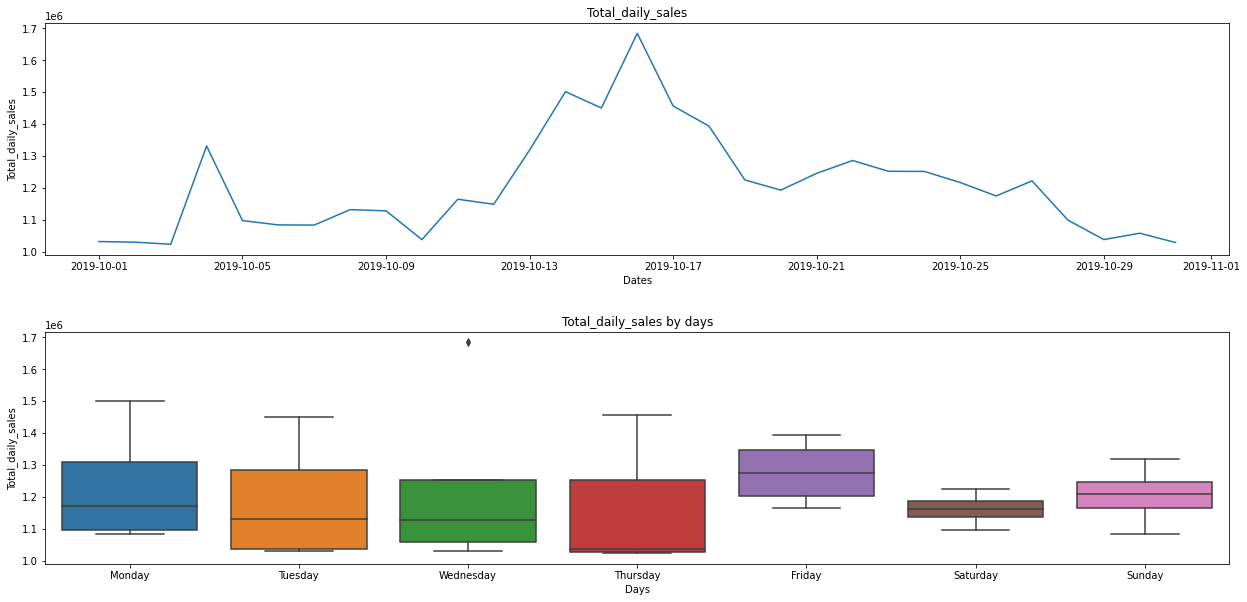

In [10]:
# 일별 구매자 수 통계 출력
daily_statistics_plot(daily_summary_table, 'Total_daily_sales')

number_of_daily_buyers Statistics
--------------------------------------------------
count      31.000000
mean     3457.612903
std       452.018044
min      2864.000000
25%      3128.000000
50%      3399.000000
75%      3767.500000
max      4873.000000
Name: number_of_daily_buyers, dtype: float64
--------------------------------------------------
number_of_daily_buyers
--------------------------------------------------
            count     mean         std     min      25%     50%      75%  \
event_time                                                                 
Friday        4.0  3626.00  245.680009  3337.0  3464.50  3664.0  3825.50   
Monday        4.0  3487.25  492.013127  3050.0  3114.50  3396.5  3769.25   
Saturday      4.0  3436.25  254.725179  3193.0  3266.50  3391.0  3560.75   
Sunday        4.0  3473.00  279.030464  3120.0  3329.25  3503.5  3647.25   
Thursday      5.0  3348.80  490.920258  2938.0  2940.00  3177.0  3613.00   
Tuesday       5.0  3355.40  481.698869  2864.

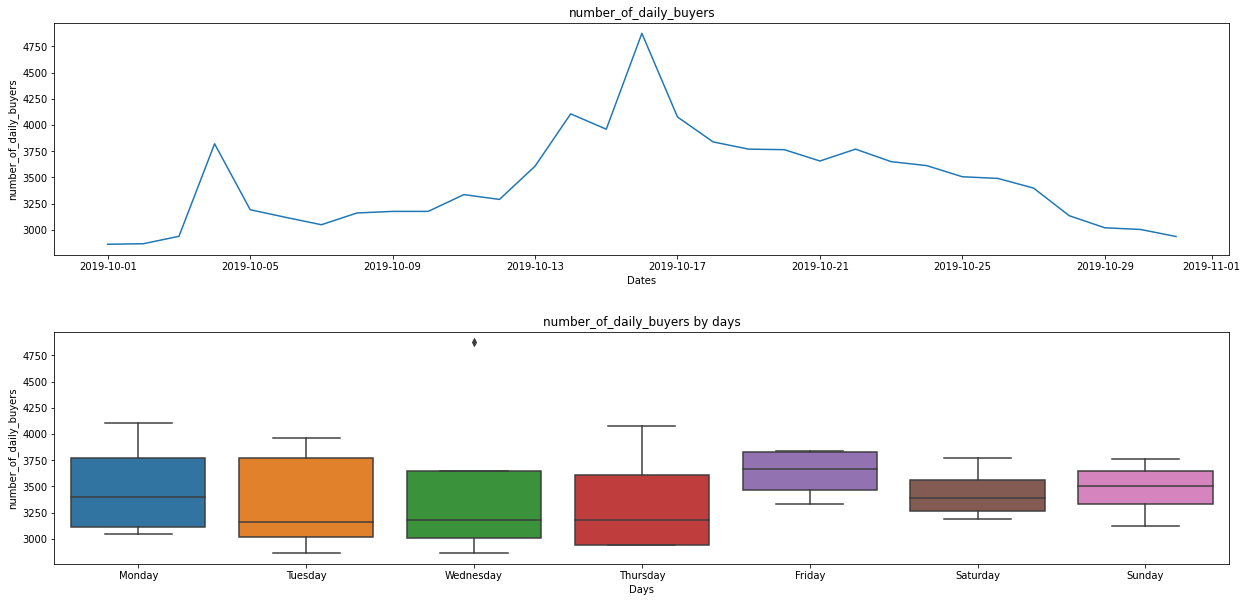

In [11]:
# 일별 구매자 수 통계 출력
daily_statistics_plot(daily_summary_table, 'number_of_daily_buyers')

conversion_rate Statistics
--------------------------------------------------
count    31.000000
mean      0.112968
std       0.010308
min       0.096118
25%       0.106910
50%       0.112456
75%       0.116310
max       0.144348
Name: conversion_rate, dtype: float64
--------------------------------------------------
conversion_rate
--------------------------------------------------
            count      mean       std       min       25%       50%       75%  \
event_time                                                                      
Friday        4.0  0.109195  0.007884  0.101648  0.105311  0.107451  0.111335   
Monday        4.0  0.118542  0.010191  0.111358  0.112599  0.114647  0.120590   
Saturday      4.0  0.109750  0.005414  0.102390  0.107559  0.110869  0.113060   
Sunday        4.0  0.108721  0.008493  0.096118  0.107591  0.112151  0.113280   
Thursday      5.0  0.112787  0.014064  0.098044  0.105273  0.108348  0.117726   
Tuesday       5.0  0.112857  0.006962  0.103849

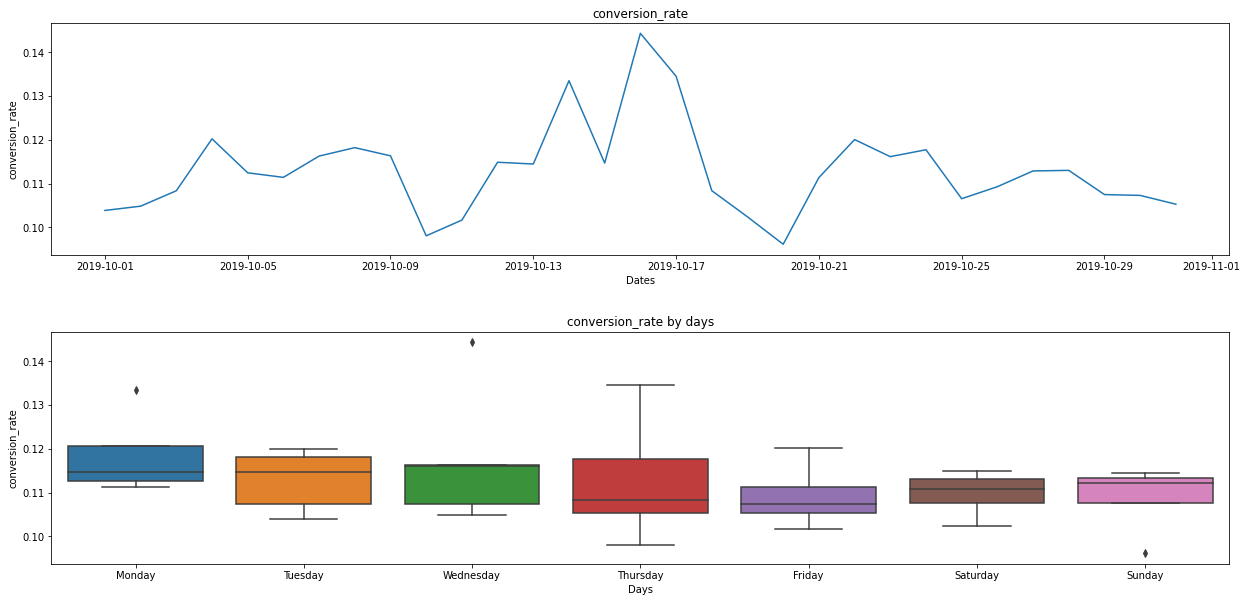

In [12]:
# 일별 전환율 통계 출력
daily_statistics_plot(daily_summary_table, 'conversion_rate')

## 1.2 구매자 분석

In [13]:
# 고객 테이블 생성
# 매출 활동 필터링
sales_filter = dataset['event_type'] == 'purchase'
Customer_table = dataset.loc[sales_filter].groupby(by=['user_id']).agg(
    number_of_purchases=('user_id', 'count'), # 고객별 구매 건수
    total_sales=('price', 'sum') # 고객별 매출 합계
    ).reset_index()

In [14]:
# 구매한 고객 수 계산
Number_of_customers_who_bought_smt = Customer_table['user_id'].nunique()
print('There are {:,.0f} customers, who purchased in October.'.format(Number_of_customers_who_bought_smt))

# 각 고객의 구매 활동 횟수 계산
print('-' * 50)
print('Distribution of Customer by Number of Purchases')
print(Customer_table['number_of_purchases'].value_counts(normalize=True).head(10))

# 반복 구매 고객 수 계산
print('-' * 50)
more_than_one_purchase_filter = Customer_table['number_of_purchases'] > 1
Number_of_customers_who_bought_more_than_once = Customer_table.loc[more_than_one_purchase_filter].shape[0]
print('There are {:,.0f} repeat customers, who bought more than once.'.format(Number_of_customers_who_bought_more_than_once))

There are 76,524 customers, who purchased in October.
--------------------------------------------------
Distribution of Customer by Number of Purchases
1     0.682270
2     0.168692
3     0.062294
4     0.029429
5     0.017014
6     0.010350
7     0.006691
8     0.004548
9     0.003659
10    0.002718
Name: number_of_purchases, dtype: float64
--------------------------------------------------
There are 24,314 repeat customers, who bought more than once.


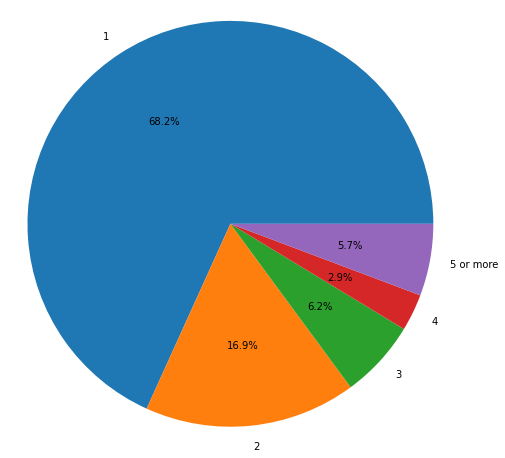

In [29]:
# 각 고객의 구매 활동 횟수 계산
purchase_counts = Customer_table['number_of_purchases'].value_counts(normalize=True)
purchase_counts = pd.concat([purchase_counts[:4], pd.Series(purchase_counts[4:].sum(), index=['5 or more'])])

# 파이차트 생성
plt.figure(figsize=(8, 8)) # 차트 크기 조정
labels = purchase_counts.index.tolist()
sizes = purchase_counts.values.tolist()
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show();

이 데이터를 다음과 같이 해석할 수 있음
1. 10월에 구매한 고객은 총 347,118명.

2. 고객들의 구매 횟수 분포:
    - 62.14%의 고객이 1회 구매
    - 18.89%의 고객이 2회 구매
    - 7.45%의 고객이 3회 구매
    - 3.77%의 고객이 4회 구매
    - 2.12%의 고객이 5회 구매

- 위 정보를 바탕으로, 고객들의 구매 패턴을 파악하고, 향후 마케팅 전략이나 제품 개발 방향에 참고가능
- 예를 들어, 한 번만 구매한 고객의 재구매율을 높이기 위한 전략을 세우거나, 이미 높은 재구매율을 보이는 고객들에게 추가적인 혜택을 제공하는 등의 방안을 고려할 수 있을 것임

In [16]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.8+ GB


            user_id  number_of_purchases    total_sales
count  7.652400e+04         76524.000000   76524.000000
mean   5.402114e+08             1.870302     488.391384
std    1.847860e+07             3.132812    1148.939389
min    4.030131e+08             1.000000      77.140000
25%    5.200048e+08             1.000000     170.790000
50%    5.437804e+08             1.000000     251.470000
75%    5.576649e+08             2.000000     494.617500
max    5.662701e+08           192.000000  152800.130000
            user_id  number_of_purchases   total_sales
count  7.199700e+04         71997.000000  71997.000000
mean   5.403549e+08             1.502521    347.582845
std    1.847215e+07             1.040747    269.184352
min    4.030131e+08             1.000000     88.800000
25%    5.202287e+08             1.000000    170.140000
50%    5.439956e+08             1.000000    250.860000
75%    5.577650e+08             2.000000    403.960000
max    5.662635e+08            15.000000   1459.350000


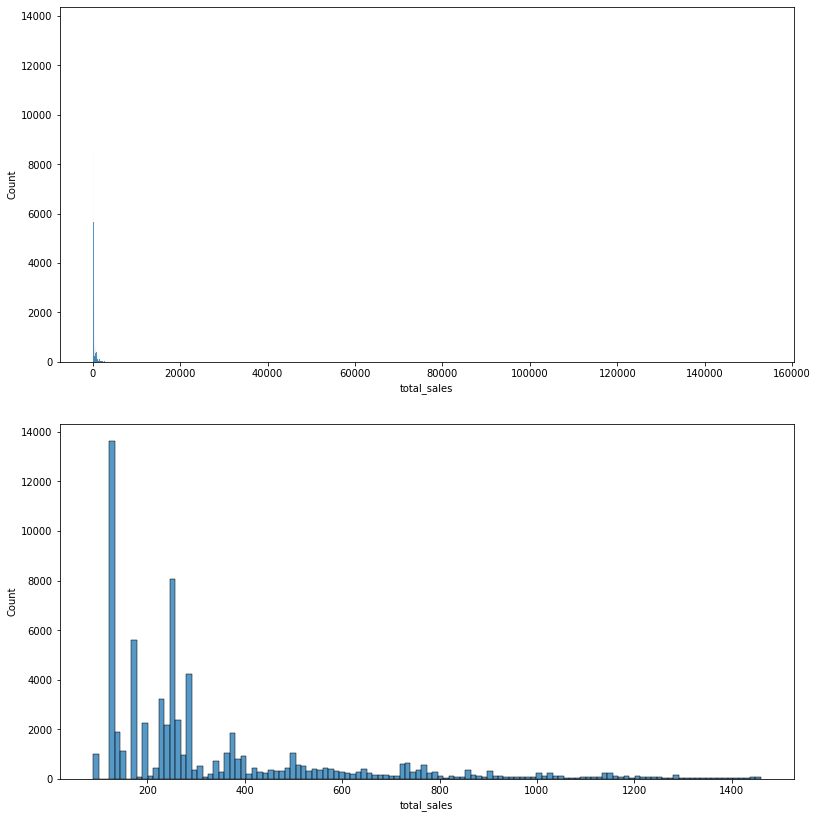

In [35]:
# 전체 매출의 1%와 95% 분위수를 계산
sales_threshold = np.percentile(Customer_table['total_sales'], [1, 95])

# 매출이 1% 이상 95% 이하인 고객 필터링
sales_threshold_filter = np.logical_and(Customer_table['total_sales'] >= sales_threshold[0],
Customer_table['total_sales'] <= sales_threshold[1])

# 필터링된 고객의 매출 데이터
sales_filtered = Customer_table.loc[sales_threshold_filter]

# 전체 고객의 매출 요약 통계 출력
print(Customer_table.describe())

# 필터링된 고객의 매출 요약 통계 출력
print(sales_filtered.describe())

# 매출 분포를 나타내는 히스토그램 그리기
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
sns.histplot(Customer_table['total_sales'], ax=ax1)

ax2 = fig.add_subplot(2, 1, 2)
sns.histplot(sales_filtered['total_sales'], ax=ax2)

# 그래프 간격 조절
fig.tight_layout(pad=3.0)

1. 이상치를 제거한 데이터를 살펴보면, 평균 구매 횟수와 평균 구매 금액이 전체 데이터보다 낮아짐
    - 이는 고객들의 대부분이 작은 금액의 구매를 주로 하고 있으며, 일부 고객이 높은 금액의 구매로 전체 평균을 올리고 있는 것을 의미


2. 이상치를 제거한 데이터의 최대 구매 금액은 1,459.3달러로, 전체 데이터의 최대 구매 금액인 152,800.1달러보다 훨씬 낮음
    - 이는 소수의 고객이 특히 높은 금액의 구매를 했음을 보여줌


3. 이상치를 제거한 데이터의 평균 구매 금액이 전체 데이터의 평균 구매 금액보다 낮으며, 중앙값 구매 금액은 거의 차이가 없음
    - 이는 소수의 고객이 높은 금액의 구매로 전체 평균을 올리고 있음을 확인할 수 있음

# 2. 문제 정의

## 2.1 문제 상황

- 프로젝트 목적 : 매출증대
- 예상 해결 방안 : Dynamic Pricing 활용

## 2.2 문제정의
- 1. Dynamic Pricing은 효과가 있을것인가?
- 2. 어떻게 Dynamic Pricing을 적용할 것인가?
    => 가설검증을 통한 필요성 제시

## 2.2 가설 설정

### 매출액과 매출
- 방문자 수와 매출 간에는 양의 상관관계가 있을 것이다.
- 구매자 수와 매출 간에는 양의 상관관계가 있을 것이다.
- 방문자 수와 구매자 간에는 양의 상관관계가 있을 것이다.
- 전환율과 매출액 간에는 양의 상관관계가 있을 것이다.
    
### 요일별 변화    

- 요일별로 매출액에는 차이가 있다.
- 요일별로 방문자 수는 차이가 있다.
- 요일별로 구매자 수는 차이가 있다.
- 요일별로 전환율은 차이가 있다.

### 판매량 변화
- 판매량 변화와 가격 변화 간에는 음의 상관관계가 있을 것이다.
- 방문 빈도 변화와 가격 변화 간에는 음의 상관관계가 있을 것이다.
- 장바구니 이용 빈도 변화와 가격 변화 간에는 음의 상관관계가 있을 것이다.

# 3. 가설 검정

- 모두 중요한 가설이지만, DP의 타당성을 확인하기 위해서는 </br> 판매량과 관련된 가설이 검증될 필요성이 있다.

### 판매량 변화
    - 판매량 변화와 가격 변화 간에는 음의 상관관계가 있을 것이다.
    - 방문 빈도 변화와 가격 변화 간에는 음의 상관관계가 있을 것이다.
    - 장바구니 이용 빈도 변화와 가격 변화 간에는 음의 상관관계가 있을 것이다.

In [36]:
df['event_time'] = df['event_time'].str[:10]

# 주차 정보 추가
df['week_id'] = pd.to_datetime(df.event_time).dt.isocalendar().week

# 이벤트별 데이터 분할
purchase = df[df.event_type == 'purchase'].reset_index(drop=True)
cart = df[df.event_type == 'cart'].reset_index(drop=True)
view = df[df.event_type == 'view'].reset_index(drop=True)


# 제품별 주차별 구매 정보 집계
purchase_df = purchase.groupby(['product_id', 'week_id']).agg({'price': 'mean', 'event_type': 'count'}).reset_index().rename(columns={'event_type': 'sales'})

# 직전 1,2,3,4주간의 판매량 계산
purchase_df['sales_last_1w'] = purchase_df.groupby('product_id')['sales'].rolling(2).sum().reset_index()['sales'] - purchase_df['sales']
purchase_df['sales_last_2w'] = purchase_df.groupby('product_id')['sales'].rolling(3).sum().reset_index()['sales'] - purchase_df['sales']
purchase_df['sales_last_3w'] = purchase_df.groupby('product_id')['sales'].rolling(4).sum().reset_index()['sales'] - purchase_df['sales']
purchase_df['sales_last_4w'] = purchase_df.groupby('product_id')['sales'].rolling(5).sum().reset_index()['sales'] - purchase_df['sales']


# 제품별 주차별 조회 정보 집계
view_df = view.groupby(['product_id', 'week_id']).agg({'event_type': 'count'}).reset_index().rename(columns={'event_type': 'views'})

# 직전 1,2,3,4 주간의 조회수 계산
view_df['views_last_1w'] = view_df.groupby('product_id')['views'].rolling(2).sum().reset_index()['views'] - view_df['views']
view_df['views_last_2w'] = view_df.groupby('product_id')['views'].rolling(3).sum().reset_index()['views'] - view_df['views']
view_df['views_last_3w'] = view_df.groupby('product_id')['views'].rolling(4).sum().reset_index()['views'] - view_df['views']
view_df['views_last_4w'] = view_df.groupby('product_id')['views'].rolling(5).sum().reset_index()['views'] - view_df['views']


# 제품별 주차별 장바구니 정보 집계
cart_df = cart.groupby(['product_id', 'week_id']).agg({'event_type': 'count'}).reset_index().rename(columns={'event_type': 'carts'})

# 직전 4주간의 장바구니 횟수 계산
cart_df['carts_last_1w'] = cart_df.groupby('product_id')['carts'].rolling(2).sum().reset_index()['carts'] - cart_df['carts']
cart_df['carts_last_2w'] = cart_df.groupby('product_id')['carts'].rolling(3).sum().reset_index()['carts'] - cart_df['carts']
cart_df['carts_last_3w'] = cart_df.groupby('product_id')['carts'].rolling(4).sum().reset_index()['carts'] - cart_df['carts']
cart_df['carts_last_4w'] = cart_df.groupby('product_id')['carts'].rolling(5).sum().reset_index()['carts'] - cart_df['carts']


# 제품 주차별 판매량 정보 집계
price_df = purchase.groupby(['product_id', 'week_id']).agg({'price': 'mean'}).reset_index()

# 직전 1,2,3,4 주간의 판매량 계산
price_df['price_last_1w'] = price_df.groupby('product_id')['price'].rolling(2).mean().reset_index()['price']
price_df['price_last_2w'] = price_df.groupby('product_id')['price'].rolling(3).mean().reset_index()['price']
price_df['price_last_3w'] = price_df.groupby('product_id')['price'].rolling(4).mean().reset_index()['price']
price_df['price_last_4w'] = price_df.groupby('product_id')['price'].rolling(5).mean().reset_index()['price']


# 구매, 조회, 장바구니 데이터를 병합하여 마스터 데이터프레임 생성
master = purchase_df.merge(view_df, on=['product_id', 'week_id'], how='left').merge(cart_df, on=['product_id', 'week_id'], how='left').merge(price_df.drop(columns=['price']), on=['product_id', 'week_id'], how='left')

#필요한 열만 선택
master = master[['week_id', 'product_id', 'sales', 'price',
                 'sales_last_1w', 'sales_last_2w', 'sales_last_3w','sales_last_4w', 
                 'views_last_1w', 'views_last_2w','views_last_3w', 'views_last_4w',
                 'carts_last_1w', 'carts_last_2w', 'carts_last_3w','carts_last_4w',
                 'price_last_1w', 'price_last_2w', 'price_last_3w','price_last_4w']]

# 주별 판매량, 조회수, 장바구니 횟수, 가격변화 비율 계산
master['sales_1w2w_ratio'] = (master.sales_last_1w - master.sales_last_2w) / master.sales_last_2w
master['sales_2w4w_ratio'] = (master.sales_last_2w - master.sales_last_4w) / master.sales_last_4w
master['sales_1w4w_ratio'] = (master.sales_last_1w - master.sales_last_4w) / master.sales_last_4w
master['sales_1w3w_ratio'] = (master.sales_last_1w - master.sales_last_3w) / master.sales_last_3w
master['sales_2w3w_ratio'] = (master.sales_last_2w - master.sales_last_3w) / master.sales_last_3w
master['sales_3w4w_ratio'] = (master.sales_last_3w - master.sales_last_4w) / master.sales_last_4w

master['views_1w2w_ratio'] = (master.views_last_1w - master.views_last_2w)/ master.views_last_2w
master['views_2w4w_ratio'] = (master.views_last_2w - master.views_last_4w)/ master.views_last_4w
master['views_1w4w_ratio'] = (master.views_last_1w - master.views_last_4w)/ master.views_last_4w
master['views_1w3w_ratio'] = (master.views_last_1w - master.views_last_3w)/ master.views_last_3w
master['views_2w3w_ratio'] = (master.views_last_2w - master.views_last_3w)/ master.views_last_3w
master['views_3w4w_ratio'] = (master.views_last_3w - master.views_last_4w)/ master.views_last_4w

master['carts_1w2w_ratio'] = (master.carts_last_1w - master.carts_last_2w)/ master.carts_last_2w
master['carts_2w4w_ratio'] = (master.carts_last_2w - master.carts_last_4w)/ master.carts_last_4w
master['carts_1w4w_ratio'] = (master.carts_last_1w - master.carts_last_4w)/ master.carts_last_4w
master['carts_1w3w_ratio'] = (master.carts_last_1w - master.carts_last_3w)/ master.carts_last_3w
master['carts_2w3w_ratio'] = (master.carts_last_2w - master.carts_last_3w)/ master.carts_last_3w
master['carts_3w4w_ratio'] = (master.carts_last_3w - master.carts_last_4w)/ master.carts_last_4w

master['price_1w2w_ratio'] = (master.price_last_1w - master.price_last_2w) / master.price_last_2w
master['price_2w4w_ratio'] = (master.price_last_2w - master.price_last_4w) /master.price_last_4w
master['price_1w4w_ratio'] = (master.price_last_1w - master.price_last_4w) /master.price_last_4w
master['price_1w3w_ratio'] = (master.price_last_1w - master.price_last_3w) /master.price_last_3w
master['price_2w3w_ratio'] = (master.price_last_2w - master.price_last_3w) /master.price_last_3w
master['price_3w4w_ratio'] = (master.price_last_3w - master.price_last_4w) /master.price_last_4w

In [37]:
import scipy.stats as stats

def calculate_pearson_corr(dataframe, column1, column2):
    corr, p_value = stats.pearsonr(dataframe[column1], dataframe[column2])
    print(f"Pearson Correlation: {corr:.2f} (p-value: {p_value:.3f})")

def perform_chi2_test(dataframe, column1, column2):
    cont_table = dataframe[[column1, column2]].values
    stat, p_value, dof, expected = stats.chi2_contingency(cont_table)
    print(f"Chi-square Test: {stat:.2f} (p-value: {p_value:.3f})")

def perform_oneway_anova(dataframe, column, groupby_column):
    groupby_table = dataframe.groupby(by=dataframe[groupby_column].dt.day_name())[column].sum().reset_index()
    groupby_list = [dataframe[dataframe[groupby_column].dt.day_name() == day][column] for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
    f_statistic, p_value = stats.f_oneway(*groupby_list)
    print(f"F-statistic: {f_statistic:.2f} (p-value: {p_value:3f})")

# 방문자 수와 매출 간의 상관관계 검증
calculate_pearson_corr(daily_summary_table, 'number_of_daily_visitors', 'Total_daily_sales')

# 구매자 수와 매출 간의 상관관계 검증
calculate_pearson_corr(daily_summary_table, 'number_of_daily_buyers', 'Total_daily_sales')

# 방문자 수와 구매자 간의 상관관계 검증.
calculate_pearson_corr(daily_summary_table, 'number_of_daily_visitors', 'number_of_daily_buyers')

#전환율과 매출액간의 상관관계 검증
calculate_pearson_corr(daily_summary_table, 'conversion_rate', 'Total_daily_sales')

# 요일별 매출액이 다를 것이다.
perform_oneway_anova(daily_summary_table, 'Total_daily_sales', 'event_time')

# 요일별로 방문자 수는 차이가 있다.
perform_oneway_anova(daily_summary_table, 'number_of_daily_visitors', 'event_time')

# 요일별로 구매자 수는 차이가 있다.
perform_oneway_anova(daily_summary_table, 'number_of_daily_buyers', 'event_time')

# 요일별로 전환율은 차이가 있다.
perform_oneway_anova(daily_summary_table, 'conversion_rate', 'event_time')

Pearson Correlation: 0.70 (p-value: 0.000)
Pearson Correlation: 0.96 (p-value: 0.000)
Pearson Correlation: 0.80 (p-value: 0.000)
Pearson Correlation: 0.74 (p-value: 0.000)
F-statistic: 0.25 (p-value: 0.955554)
F-statistic: 0.95 (p-value: 0.477146)
F-statistic: 0.17 (p-value: 0.982832)
F-statistic: 0.59 (p-value: 0.733027)


In [38]:
# 판매량 변화와 가격 변화 간의 상관관계
table = master[['sales_1w2w_ratio', 'price_1w2w_ratio']].dropna()
calculate_pearson_corr(table, 'sales_1w2w_ratio', 'price_1w2w_ratio')

# 방문 빈도 변화와 가격 변화 간의 상관관계
table = master[['views_1w2w_ratio', 'price_1w2w_ratio']].dropna()
calculate_pearson_corr(table, 'views_1w2w_ratio', 'price_1w2w_ratio')

# 장바구니 이용 빈도 변화와 가격 변화 간의 상관관계
table = master[['carts_1w2w_ratio', 'price_1w2w_ratio']].dropna()
calculate_pearson_corr(table, 'carts_1w2w_ratio', 'price_1w2w_ratio')

Pearson Correlation: -0.22 (p-value: 0.000)
Pearson Correlation: -0.21 (p-value: 0.000)
Pearson Correlation: -0.18 (p-value: 0.023)


# 4. 해결 방안 제시

### 4.1 미래 판매량과 미래 가격
- 본 과제에서는 XGBoost를 이용하여 미래 판매량과 미래가격을 예측하고, 최적화 알고리즘을 적용하여 매출을 극대화하는 적정가격을 찾고자 함


### 4.2 최적화
- 변수 정의
$$ P_i = \{ i|i = Price\,of\,product\,id(i)\} $$

$$ Q_i = \{ i|i = Quantity\,of\,product\,id(i)\} $$

$$ P_{pred_i} = \{ i|i = Predicted\,price\,of\,product\,id(i)\} $$

$$ Q_{pred_i} = \{ i|i = Predicted\,quantity\,of\,product\,id(i)\} $$






- 목적식과 제약식
$$ Max:  \displaystyle\sum_{i=1}^{n} P_{pred_i}  * Q_{pred_i} $$

$$ Constraints_1 : 0.95 P_i< P_{pred_i} $$

$$ Constraints_2 : P_{pred_i} < 1.1P_i$$

In [21]:
print(list(master))

['week_id', 'product_id', 'sales', 'price', 'sales_last_1w', 'sales_last_2w', 'sales_last_3w', 'sales_last_4w', 'views_last_1w', 'views_last_2w', 'views_last_3w', 'views_last_4w', 'carts_last_1w', 'carts_last_2w', 'carts_last_3w', 'carts_last_4w', 'price_last_1w', 'price_last_2w', 'price_last_3w', 'price_last_4w', 'sales_1w2w_ratio', 'sales_2w4w_ratio', 'sales_1w4w_ratio', 'sales_1w3w_ratio', 'sales_2w3w_ratio', 'sales_3w4w_ratio', 'views_1w2w_ratio', 'views_2w4w_ratio', 'views_1w4w_ratio', 'views_1w3w_ratio', 'views_2w3w_ratio', 'views_3w4w_ratio', 'carts_1w2w_ratio', 'carts_2w4w_ratio', 'carts_1w4w_ratio', 'carts_1w3w_ratio', 'carts_2w3w_ratio', 'carts_3w4w_ratio', 'price_1w2w_ratio', 'price_2w4w_ratio', 'price_1w4w_ratio', 'price_1w3w_ratio', 'price_2w3w_ratio', 'price_3w4w_ratio']


In [43]:
import xgboost as xgb

# 특성 목록 생성
features_for_sales = ['price', 'sales_last_1w', 'sales_last_2w', 'sales_last_3w', 'sales_last_4w', 'views_last_1w', 'views_last_2w', 'views_last_3w', 'views_last_4w', 'carts_last_1w', 'carts_last_2w', 'carts_last_3w', 'carts_last_4w', 'price_last_1w', 'price_last_2w', 'price_last_3w', 'price_last_4w', 'sales_1w2w_ratio', 'sales_2w4w_ratio', 'sales_1w4w_ratio', 'sales_1w3w_ratio', 'sales_2w3w_ratio', 'sales_3w4w_ratio', 'views_1w2w_ratio', 'views_2w4w_ratio', 'views_1w4w_ratio', 'views_1w3w_ratio', 'views_2w3w_ratio', 'views_3w4w_ratio', 'carts_1w2w_ratio', 'carts_2w4w_ratio', 'carts_1w4w_ratio', 'carts_1w3w_ratio', 'carts_2w3w_ratio', 'carts_3w4w_ratio', 'price_1w2w_ratio', 'price_2w4w_ratio', 'price_1w4w_ratio', 'price_1w3w_ratio', 'price_2w3w_ratio', 'price_3w4w_ratio']
features_for_price = ['sales', 'sales_last_1w', 'sales_last_2w', 'sales_last_3w', 'sales_last_4w', 'views_last_1w', 'views_last_2w', 'views_last_3w', 'views_last_4w', 'carts_last_1w', 'carts_last_2w', 'carts_last_3w', 'carts_last_4w', 'price_last_1w', 'price_last_2w', 'price_last_3w', 'price_last_4w', 'sales_1w2w_ratio', 'sales_2w4w_ratio', 'sales_1w4w_ratio', 'sales_1w3w_ratio', 'sales_2w3w_ratio', 'sales_3w4w_ratio', 'views_1w2w_ratio', 'views_2w4w_ratio', 'views_1w4w_ratio', 'views_1w3w_ratio', 'views_2w3w_ratio', 'views_3w4w_ratio', 'carts_1w2w_ratio', 'carts_2w4w_ratio', 'carts_1w4w_ratio', 'carts_1w3w_ratio', 'carts_2w3w_ratio', 'carts_3w4w_ratio', 'price_1w2w_ratio', 'price_2w4w_ratio', 'price_1w4w_ratio', 'price_1w3w_ratio', 'price_2w3w_ratio', 'price_3w4w_ratio']


# 훈련 데이터와 테스트 데이터로 나눔
train = master[master.week_id.isin([40, 41, 42, 43])]
test = master[master.week_id.isin([44])]

# 수요 예측 모델 정의
clf_sales = xgb.XGBRegressor(n_estimators=100000, learning_rate=0.01, early_stopping_rounds=20)

# 모델 훈련
clf_sales.fit(
    train[features_for_sales],
    train['sales'],
    eval_set=[
        (train[features_for_sales], train['sales']),
        (test[features_for_sales], test['sales'])
    ],
    eval_metric='rmse',  # 사용자 정의 평가 함수
    verbose=True
)

test['sales_prediction']=clf_sales.predict(test[features_for_sales])


# 가격 예측 모델 정의
clf_price = xgb.XGBRegressor(n_estimators=100000,
                             learning_rate=0.01,
                             early_stopping_rounds=20)

# 모델 훈련
clf_price.fit(
    train[features_for_price],
    train['price'],
    eval_set=[
        (train[features_for_price], train['price']),
        (test[features_for_price], test['price'])
    ],
    eval_metric='rmse',  # 사용자 정의 평가 함수
    verbose=True
)

test['price_prediction']=clf_price.predict(test[features_for_price])

[0]	validation_0-rmse:858.37505	validation_1-rmse:431.11146
[1]	validation_0-rmse:851.99515	validation_1-rmse:422.77523
[2]	validation_0-rmse:845.67892	validation_1-rmse:414.53098
[3]	validation_0-rmse:839.30226	validation_1-rmse:406.34433
[4]	validation_0-rmse:832.98735	validation_1-rmse:398.23888
[5]	validation_0-rmse:826.85506	validation_1-rmse:390.22798
[6]	validation_0-rmse:820.66084	validation_1-rmse:382.28377
[7]	validation_0-rmse:814.52698	validation_1-rmse:374.41499
[8]	validation_0-rmse:808.45257	validation_1-rmse:366.64793
[9]	validation_0-rmse:802.43737	validation_1-rmse:358.94794
[10]	validation_0-rmse:796.63725	validation_1-rmse:351.31285
[11]	validation_0-rmse:790.89574	validation_1-rmse:343.76297
[12]	validation_0-rmse:785.05218	validation_1-rmse:336.29778
[13]	validation_0-rmse:779.42468	validation_1-rmse:328.88241
[14]	validation_0-rmse:773.85445	validation_1-rmse:321.55460
[15]	validation_0-rmse:768.34090	validation_1-rmse:314.48330
[16]	validation_0-rmse:762.71883	v

C:\Users\Sunwoo\Anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Sunwoo\AppData\Local\Temp\ipykernel_8832\1685573995.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sales_prediction']=clf_sales.predict(test[features_for_sales])


[0]	validation_0-rmse:632.68417	validation_1-rmse:656.48018
[1]	validation_0-rmse:627.03439	validation_1-rmse:650.14727
[2]	validation_0-rmse:621.44498	validation_1-rmse:643.89218
[3]	validation_0-rmse:615.91547	validation_1-rmse:637.70012
[4]	validation_0-rmse:610.44523	validation_1-rmse:631.55485
[5]	validation_0-rmse:605.03375	validation_1-rmse:625.48531
[6]	validation_0-rmse:599.68168	validation_1-rmse:619.44974
[7]	validation_0-rmse:594.38601	validation_1-rmse:613.50071
[8]	validation_0-rmse:589.14739	validation_1-rmse:607.69009
[9]	validation_0-rmse:583.96515	validation_1-rmse:601.87269
[10]	validation_0-rmse:578.83929	validation_1-rmse:596.19049
[11]	validation_0-rmse:573.76931	validation_1-rmse:590.44874
[12]	validation_0-rmse:568.75370	validation_1-rmse:584.87920
[13]	validation_0-rmse:563.79290	validation_1-rmse:579.26309
[14]	validation_0-rmse:558.88581	validation_1-rmse:573.80311
[15]	validation_0-rmse:554.03226	validation_1-rmse:568.30194
[16]	validation_0-rmse:549.22891	v

C:\Users\Sunwoo\Anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[107]	validation_0-rmse:276.43657	validation_1-rmse:238.25527
[108]	validation_0-rmse:274.81625	validation_1-rmse:236.06840
[109]	validation_0-rmse:273.18369	validation_1-rmse:233.90556
[110]	validation_0-rmse:271.60623	validation_1-rmse:231.74653
[111]	validation_0-rmse:270.04889	validation_1-rmse:229.62105
[112]	validation_0-rmse:268.45341	validation_1-rmse:227.53926
[113]	validation_0-rmse:266.91472	validation_1-rmse:225.45308
[114]	validation_0-rmse:265.38195	validation_1-rmse:223.39639
[115]	validation_0-rmse:263.88145	validation_1-rmse:221.28812
[116]	validation_0-rmse:262.36890	validation_1-rmse:219.22319
[117]	validation_0-rmse:260.91335	validation_1-rmse:217.21442
[118]	validation_0-rmse:259.49325	validation_1-rmse:215.25046
[119]	validation_0-rmse:258.07135	validation_1-rmse:213.23032
[120]	validation_0-rmse:256.65364	validation_1-rmse:211.26800
[121]	validation_0-rmse:255.27501	validation_1-rmse:209.32442
[122]	validation_0-rmse:253.90964	validation_1-rmse:207.35400
[123]	va

[240]	validation_0-rmse:174.38663	validation_1-rmse:72.74284
[241]	validation_0-rmse:174.14652	validation_1-rmse:72.13712
[242]	validation_0-rmse:173.93301	validation_1-rmse:71.53564
[243]	validation_0-rmse:173.64153	validation_1-rmse:70.94002
[244]	validation_0-rmse:173.41162	validation_1-rmse:70.35147
[245]	validation_0-rmse:173.15380	validation_1-rmse:69.77470
[246]	validation_0-rmse:172.87393	validation_1-rmse:69.19593
[247]	validation_0-rmse:172.65385	validation_1-rmse:68.62066
[248]	validation_0-rmse:172.38137	validation_1-rmse:68.06354
[249]	validation_0-rmse:172.16780	validation_1-rmse:67.49966
[250]	validation_0-rmse:171.97963	validation_1-rmse:66.94346
[251]	validation_0-rmse:171.76984	validation_1-rmse:66.39933
[252]	validation_0-rmse:171.49713	validation_1-rmse:65.87417
[253]	validation_0-rmse:171.22865	validation_1-rmse:65.35409
[254]	validation_0-rmse:170.96246	validation_1-rmse:64.83961
[255]	validation_0-rmse:170.76456	validation_1-rmse:64.31724
[256]	validation_0-rmse:

[375]	validation_0-rmse:156.57504	validation_1-rmse:28.43585
[376]	validation_0-rmse:156.54283	validation_1-rmse:28.28863
[377]	validation_0-rmse:156.50214	validation_1-rmse:28.13686
[378]	validation_0-rmse:156.42941	validation_1-rmse:27.99684
[379]	validation_0-rmse:156.39800	validation_1-rmse:27.85634
[380]	validation_0-rmse:156.32635	validation_1-rmse:27.72149
[381]	validation_0-rmse:156.28713	validation_1-rmse:27.58114
[382]	validation_0-rmse:156.21679	validation_1-rmse:27.45016
[383]	validation_0-rmse:156.14747	validation_1-rmse:27.32115
[384]	validation_0-rmse:156.09819	validation_1-rmse:27.19176
[385]	validation_0-rmse:156.06873	validation_1-rmse:27.06518
[386]	validation_0-rmse:156.03130	validation_1-rmse:26.93626
[387]	validation_0-rmse:155.96377	validation_1-rmse:26.81412
[388]	validation_0-rmse:155.89721	validation_1-rmse:26.69389
[389]	validation_0-rmse:155.86133	validation_1-rmse:26.58083
[390]	validation_0-rmse:155.79597	validation_1-rmse:26.45824
[391]	validation_0-rmse:

[510]	validation_0-rmse:152.06230	validation_1-rmse:20.28317
[511]	validation_0-rmse:152.04566	validation_1-rmse:20.27794
[512]	validation_0-rmse:152.02928	validation_1-rmse:20.27397
[513]	validation_0-rmse:152.01785	validation_1-rmse:20.27476
[514]	validation_0-rmse:151.98388	validation_1-rmse:20.24318
[515]	validation_0-rmse:151.96912	validation_1-rmse:20.24630
[516]	validation_0-rmse:151.93690	validation_1-rmse:20.19674
[517]	validation_0-rmse:151.92103	validation_1-rmse:20.19517
[518]	validation_0-rmse:151.90658	validation_1-rmse:20.19951
[519]	validation_0-rmse:151.89100	validation_1-rmse:20.19957
[520]	validation_0-rmse:151.87769	validation_1-rmse:20.18717
[521]	validation_0-rmse:151.84620	validation_1-rmse:20.14388
[522]	validation_0-rmse:151.83104	validation_1-rmse:20.14566
[523]	validation_0-rmse:151.79153	validation_1-rmse:20.11612
[524]	validation_0-rmse:151.77745	validation_1-rmse:20.12221
[525]	validation_0-rmse:151.76358	validation_1-rmse:20.12893
[526]	validation_0-rmse:

C:\Users\Sunwoo\AppData\Local\Temp\ipykernel_8832\1685573995.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['price_prediction']=clf_price.predict(test[features_for_price])


## 모델 평가

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

mae = mean_absolute_error(clf_price.predict(test[features_for_price]), test['price'])
mse = mean_squared_error(clf_price.predict(test[features_for_price]), test['price'])
rmse = mean_squared_error(clf_price.predict(test[features_for_price]), test['price'], squared=False)
mape_val = mape(clf_price.predict(test[features_for_price]), test['price'])

print("MAE: ", round(mae,2))
print("MSE: ", round(mse,2))
print("RMSE: ", round(rmse,2))
print("MAPE: ", round(mape_val,2))

MAE:  11.91
MSE:  399.23
RMSE:  19.98
MAPE:  0.02


In [45]:
mae = mean_absolute_error(clf_sales.predict(test[features_for_sales]), test['sales'])
mse = mean_squared_error(clf_sales.predict(test[features_for_sales]), test['sales'])
rmse = mean_squared_error(clf_sales.predict(test[features_for_sales]), test['sales'], squared=False)
mape_val = mape(clf_sales.predict(test[features_for_sales]), test['sales'])

print("MAE: ", round(mae,2))
print("MSE: ", round(mse,2))
print("RMSE: ", round(rmse,2))
print("MAPE: ", round(mape_val ,2))

MAE:  29.89
MSE:  5275.53
RMSE:  72.63
MAPE:  0.46


# Dynamic Pricing 구현

In [46]:
# scipy.optimize의 minimize 함수를 임포트
from scipy.optimize import minimize
from tqdm import tqdm

def dynamic_programming(max_rate, min_rate):
    # 결과를 저장할 빈 리스트 생성
    results = []
    # 각 상품의 가격과 판매량 데이터를 저장하는 데이터프레임을 estimate 변수에 저장
    estimate = test[['product_id','price','sales']]

    # estimate 데이터프레임의 모든 고유한 product_id에 대해 반복
    for product_id in tqdm(test.product_id.unique()):
        # 결과를 저장할 딕셔너리 초기화
        entry = {}
        entry['product_id'] = product_id

        # 현재 product_id에 해당하는 데이터만 추출
        sample = test[test['product_id'] == product_id]

        # 최소 및 최대 가격 범위 설정
        lowest = sample.price * min_rate
        highest = sample.price * max_rate

        # 제약 조건 1: 가격이 최소값보다 크거나 같아야 함
        con1 = {'type': 'ineq', 'fun': lambda x: x - lowest}
        # 제약 조건 2: 가격이 최대값보다 작거나 같아야 함
        con2 = {'type': 'ineq', 'fun': lambda x: highest - x}

        # 제약 조건들을 리스트에 추가
        cons = ([con1, con2])

        # 목적 함수 정의: 매출을 최대화하는 가격을 찾기 위해 최적화(x는 가격)
        func = lambda x: -int(clf_sales.predict(np.array([x] +sample[features_for_sales].iloc[0,1:].tolist(), dtype=object).reshape(1,-1)))*x

        # SLSQP(Sequential Least Squares Quadratic Programming) 방법을 사용하여 최적화 문제 해결
        # 제약 조건과 목적 함수를 이용해 최적화 수행
        res = minimize(func, x0=0, method='SLSQP', constraints=cons)

        # 최적화된 가격과 판매량을 결과 딕셔너리에 추가
        entry['optimized_price'] = res.x[0]
        entry['optimized_sales'] = int(clf_sales.predict(np.array([res.x[0]] +sample[features_for_sales].iloc[0,1:].tolist(), dtype=object).reshape(1,-1)))

        # 결과 딕셔너리를 결과 리스트에 추가
        results.append(entry)

    # 결과 리스트를 데이터프레임으로 변환한 뒤, 각각의 열의 데이터 타입을 맞춰줌
    estimate=estimate.merge(pd.DataFrame(results),how='left',on='product_id')
    estimate.optimized_sales.astype("float")

    # 결과 데이터프레임 반환
    return estimate

# 5. 효과 검증
### 5.1 민감도 분석
- 제약식의 수식을 조금씩 변형하여 어떤 변화를 일으키는지 확인하고자 함
- 제약식을 수정하여 민감도 분석을 수행한 결과, 가격 범위가 넓어질 수록 예상 매출 증가율이 높아지는 것을 확인 할 수 있었음
- 한편, 가격 상승에 대한 예상치 못한 부작용과 가격하한이 낮아지더라도 예상 매출 증가율이 높아지는 것을 고려할 때, <br/>가격 하한을 낮추어 본 방법론의 Dynamic Pricing을 수행하는 것을 제안함

$$ Constraints_1 : 0.95 P_i< P_{pred_i} $$

$$ Constraints_2 : P_{pred_i} < 1.05P_i$$

In [47]:
estimate = dynamic_programming(1.05, 0.95)
estimate = estimate.merge(test[['product_id', 'price_prediction', 'sales_prediction']],how='left',on='product_id')

sale_44w = (estimate.price * estimate.sales).sum()
sale_44w_pred = (estimate.price_prediction * estimate.sales_prediction).sum()
sale_44w_opt = (estimate.optimized_price * estimate.optimized_sales).sum()

print('매출(실제)   :', round(sale_44w, 2))
print('매출(예측)   :', round(sale_44w_pred, 2))
print('매출(최적화):',round(sale_44w_opt, 2))
print('예상 매출 증가율:',round(sale_44w_opt/sale_44w_pred -1, 2))

100%|██████████| 109/109 [00:03<00:00, 30.73it/s]

매출(실제)   : 4221609.1
매출(예측)   : 4206942.5
매출(최적화): 4439896.54
예상 매출 증가율: 0.06


$$ Constraints_1 : 0.90 P_i< P_{pred_i} $$

$$ Constraints_2 : P_{pred_i} < 1.05P_i$$

In [48]:
estimate = dynamic_programming(1.05, 0.90)
estimate = estimate.merge(test[['product_id', 'price_prediction', 'sales_prediction']],how='left',on='product_id')

sale_44w = (estimate.price * estimate.sales).sum()
sale_44w_pred = (estimate.price_prediction * estimate.sales_prediction).sum()
sale_44w_opt = (estimate.optimized_price * estimate.optimized_sales).sum()

print('매출(실제)   :', round(sale_44w, 2))
print('매출(예측)   :', round(sale_44w_pred, 2))
print('매출(최적화):',round(sale_44w_opt, 2))
print('예상 매출 증가율:',round(sale_44w_opt/sale_44w_pred -1, 2))

100%|██████████| 109/109 [00:03<00:00, 27.60it/s]


매출(실제)   : 4221609.1
매출(예측)   : 4206942.5
매출(최적화): 4444382.43
예상 매출 증가율: 0.06


$$ Constraints_1 : 0.9 P_i< P_{pred_i} $$

$$ Constraints_2 : P_{pred_i} < 1.1P_i$$

In [49]:
estimate = dynamic_programming(1.1, 0.90)
estimate = estimate.merge(test[['product_id', 'price_prediction', 'sales_prediction']],how='left',on='product_id')

sale_44w = (estimate.price * estimate.sales).sum()
sale_44w_pred = (estimate.price_prediction * estimate.sales_prediction).sum()
sale_44w_opt = (estimate.optimized_price * estimate.optimized_sales).sum()

print('매출(실제)   :', round(sale_44w, 2))
print('매출(예측)   :', round(sale_44w_pred, 2))
print('매출(최적화):',round(sale_44w_opt, 2))
print('예상 매출 증가율:',round(sale_44w_opt/sale_44w_pred -1, 2))

100%|██████████| 109/109 [00:06<00:00, 17.48it/s]

매출(실제)   : 4221609.1
매출(예측)   : 4206942.5
매출(최적화): 4700026.15
예상 매출 증가율: 0.12


$$ Constraints_1 : 0.8 P_i< P_{pred_i} $$

$$ Constraints_2 : P_{pred_i} < 1.1P_i$$

In [50]:
estimate = dynamic_programming(1.1, 0.8)
estimate = estimate.merge(test[['product_id', 'price_prediction', 'sales_prediction']],how='left',on='product_id')

sale_44w = (estimate.price * estimate.sales).sum()
sale_44w_pred = (estimate.price_prediction * estimate.sales_prediction).sum()
sale_44w_opt = (estimate.optimized_price * estimate.optimized_sales).sum()

print('매출(실제)   :', round(sale_44w, 2))
print('매출(예측)   :', round(sale_44w_pred, 2))
print('매출(최적화):',round(sale_44w_opt, 2))
print('예상 매출 증가율:',round(sale_44w_opt/sale_44w_pred -1, 2))

100%|██████████| 109/109 [00:04<00:00, 24.97it/s]

매출(실제)   : 4221609.1
매출(예측)   : 4206942.5
매출(최적화): 4787299.11
예상 매출 증가율: 0.14
